In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**8. In this exercise, we will generate simulated data, and will then use
this data to perform best subset selection.
(a) Use the rnorm() function to generate a predictor X of length
n = 100, as well as a noise vector ? of length n = 100.**

In [3]:
np.random.seed(1)
#X =  np.random.normal(loc = 0.0, scale = 1.0, size = 100)
X =  np.random.normal(0.0, 1.0, 100)
epsilon = np.random.normal(0.0, 1.0, 100)

**(b) Generate a response vector Y of length n = 100 according to
the model
Y = β 0 + β 1 X + β 2 X 2 + β 3 X 3 + ?,
where β 0 , β 1 , β 2 , and β 3 are constants of your choice.**

In [4]:
y = 1 + 1 * X + 2 * (X ** 2) + 3 * (X ** 3) + epsilon

**(c) Use the regsubsets() function to perform best subset selection
in order to choose the best model containing the predictors
X,X 2 ,...,X 10 . What is the best model obtained according to
C p , BIC, and adjusted R 2 ? Show some plots to provide evidence
for your answer, and report the coefficients of the best model ob-
tained. Note you will need to use the data.frame() function to
create a single data set containing both X and Y .**

In [5]:
#实现一个按照RSS（或者其他评估）来量化的regsubsets函数
import itertools
def regsubsets(model,dataset,nvmax = 8,method = 'full',scale = 'rss'):
    y,X = patsy.dmatrices(model, data = dataset, return_type="dataframe")
    X_columns = list(X.columns)
    try:
        X_columns.remove('Intercept')
    except:
        pass
    if nvmax > len(X_columns):
        nvmax = len(X_columns)
    all_data_dict = {}
    if method == 'full':
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            for X_columns_nv in itertools.combinations(X_columns,nv):
                X_columns_nv = list(X_columns_nv)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
    elif method == 'forward':
        all_data_dict[0] = {}
        all_data_dict[0]['X_columns'] = []
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            X_columns_others = X_columns.copy()
            for column_value in all_data_dict[nv - 1]['X_columns']:
                X_columns_others.remove(column_value)
            for column_value in X_columns_others:
                X_columns_nv = all_data_dict[nv - 1]['X_columns'].copy()
                X_columns_nv.append(column_value)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
        del all_data_dict[0]
    elif method == 'backward':
        for nv in reversed(range(1,len(X_columns) + 1)):
            nv_scale = None
            nv_result = {}
            if nv == len(X_columns):
                nv_X_columns = X_columns
            else:
                for column_value in all_data_dict[nv + 1]['X_columns']:
                    X_columns_nv = all_data_dict[nv + 1]['X_columns'].copy()
                    X_columns_nv.remove(column_value)
                    X_model = sm.add_constant(X[X_columns_nv])
                    results = sm.OLS(y, X_model).fit()
                    nv_result['rss'] = results.ssr
                    nv_result['rsq'] = -results.rsquared
                    nv_result['adjr2'] = -results.rsquared_adj
                    nv_result['cp'] = results.aic
                    nv_result['bic'] = results.bic
                    if nv_scale == None or nv_scale > nv_result[scale]:
                        nv_scale = nv_result[scale]
                        nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
            for nv in range(nvmax + 1,len(X_columns) + 1):
                del all_data_dict[nv]
    return pd.DataFrame(all_data_dict).T.sort_index()

In [6]:
def patsy_model_poly(factor,degree = 2):
    model_poly = factor
    for i in range(2,degree + 1):
        model_poly = model_poly + '+ I(' + factor +  '**{})'.format(str(i))
    return model_poly
model = 'y ~ {}'.format(patsy_model_poly('X',10))
dataset = pd.DataFrame({'y':y,'X':X,'eps':epsilon})

In [7]:
reg = regsubsets(model,dataset,10)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


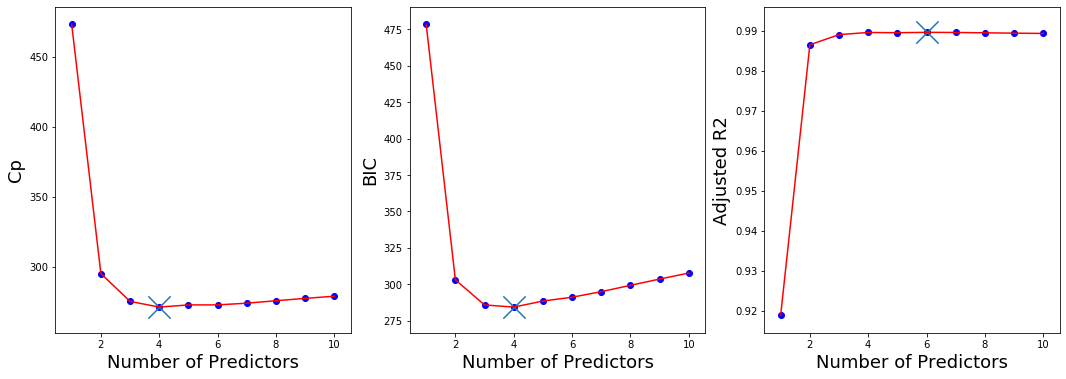

In [8]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(range(1,11),reg['cp'],'r-')
plt.scatter(range(1,11),reg['cp'],color = 'b')
plt.scatter(reg['cp'].astype('float64').idxmin(),reg['cp'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Cp", fontsize=18)
plt.subplot(132)
plt.plot(range(1,11),reg['bic'],'r-')
plt.scatter(range(1,11),reg['bic'],color = 'b')
plt.scatter(reg['bic'].astype('float64').idxmin(),reg['bic'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"BIC", fontsize=18)
plt.subplot(133)
plt.plot(range(1,11),reg['adjr2'],'r-')
plt.scatter(range(1,11),reg['adjr2'],color = 'b')
plt.scatter(reg['adjr2'].astype('float64').idxmax(),reg['adjr2'].max(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Adjusted R2", fontsize=18)
plt.show()

In [9]:
print('best model obtained according to Cp:\n', reg['params'][reg['cp'].astype('float64').idxmin()])
print('best model obtained according to bic:\n', reg['params'][reg['bic'].astype('float64').idxmin()])
print('best model obtained according to adjr2:\n', reg['params'][reg['adjr2'].astype('float64').idxmax()])

best model obtained according to Cp:
 const        1.276949
X            0.910076
I(X ** 2)    1.657467
I(X ** 3)    3.105378
I(X ** 6)    0.020949
dtype: float64
best model obtained according to bic:
 const        1.276949
X            0.910076
I(X ** 2)    1.657467
I(X ** 3)    3.105378
I(X ** 6)    0.020949
dtype: float64
best model obtained according to adjr2:
 const         1.306237
X             1.830784
I(X ** 2)     1.598661
I(X ** 5)     2.661127
I(X ** 7)    -0.788863
I(X ** 9)     0.074997
I(X ** 10)    0.001251
dtype: float64


**(d) Repeat (c), using forward stepwise selection and also using back-
wards stepwise selection. How does your answer compare to the
results in (c)?**

In [10]:
reg_forward = regsubsets(model,dataset,10,method = 'forward')

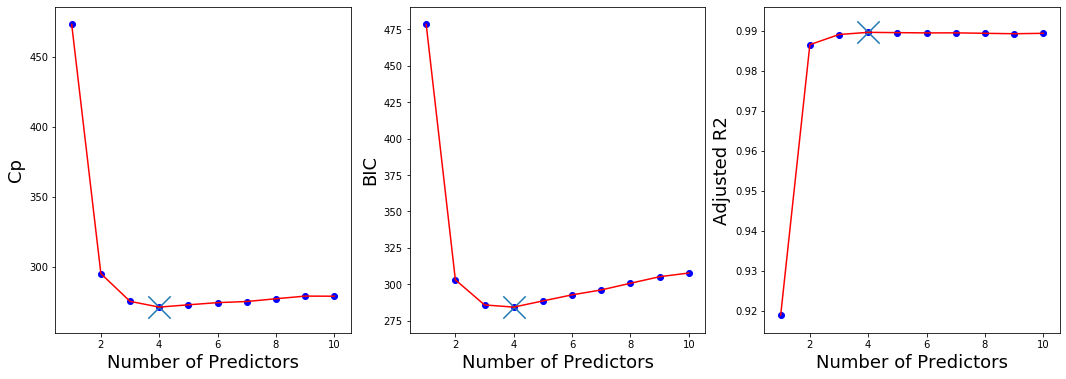

In [11]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(range(1,11),reg_forward['cp'],'r-')
plt.scatter(range(1,11),reg_forward['cp'],color = 'b')
plt.scatter(reg_forward['cp'].astype('float64').idxmin(),reg_forward['cp'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Cp", fontsize=18)
plt.subplot(132)
plt.plot(range(1,11),reg_forward['bic'],'r-')
plt.scatter(range(1,11),reg_forward['bic'],color = 'b')
plt.scatter(reg_forward['bic'].astype('float64').idxmin(),reg_forward['bic'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"BIC", fontsize=18)
plt.subplot(133)
plt.plot(range(1,11),reg_forward['adjr2'],'r-')
plt.scatter(range(1,11),reg_forward['adjr2'],color = 'b')
plt.scatter(reg_forward['adjr2'].astype('float64').idxmax(),reg_forward['adjr2'].max(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Adjusted R2", fontsize=18)
plt.show()

In [12]:
print('best model obtained according to Cp:\n', reg_forward['params'][reg_forward['cp'].astype('float64').idxmin()])
print('best model obtained according to bic:\n', reg_forward['params'][reg_forward['bic'].astype('float64').idxmin()])
print('best model obtained according to adjr2:\n', reg_forward['params'][reg_forward['adjr2'].astype('float64').idxmax()])

best model obtained according to Cp:
 const        1.276949
I(X ** 3)    3.105378
I(X ** 2)    1.657467
X            0.910076
I(X ** 6)    0.020949
dtype: float64
best model obtained according to bic:
 const        1.276949
I(X ** 3)    3.105378
I(X ** 2)    1.657467
X            0.910076
I(X ** 6)    0.020949
dtype: float64
best model obtained according to adjr2:
 const        1.276949
I(X ** 3)    3.105378
I(X ** 2)    1.657467
X            0.910076
I(X ** 6)    0.020949
dtype: float64


In [13]:
reg_backward = regsubsets(model,dataset,10,method = 'backward')

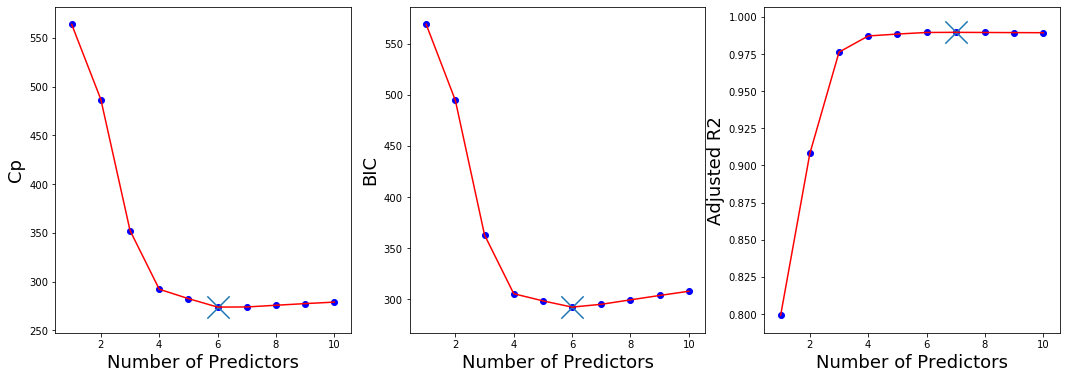

In [14]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(range(1,11),reg_backward['cp'],'r-')
plt.scatter(range(1,11),reg_backward['cp'],color = 'b')
plt.scatter(reg_backward['cp'].astype('float64').idxmin(),reg_backward['cp'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Cp", fontsize=18)
plt.subplot(132)
plt.plot(range(1,11),reg_backward['bic'],'r-')
plt.scatter(range(1,11),reg_backward['bic'],color = 'b')
plt.scatter(reg_backward['bic'].astype('float64').idxmin(),reg_backward['bic'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"BIC", fontsize=18)
plt.subplot(133)
plt.plot(range(1,11),reg_backward['adjr2'],'r-')
plt.scatter(range(1,11),reg_backward['adjr2'],color = 'b')
plt.scatter(reg_backward['adjr2'].astype('float64').idxmax(),reg_backward['adjr2'].max(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Adjusted R2", fontsize=18)
plt.show()

In [15]:
print('best model obtained according to Cp:\n', reg_backward['params'][reg_backward['cp'].astype('float64').idxmin()])
print('best model obtained according to bic:\n', reg_backward['params'][reg_backward['bic'].astype('float64').idxmin()])
print('best model obtained according to adjr2:\n', reg_backward['params'][reg_backward['adjr2'].astype('float64').idxmax()])

best model obtained according to Cp:
 const        1.341533
X            1.892792
I(X ** 2)    1.473120
I(X ** 5)    2.515252
I(X ** 6)    0.032140
I(X ** 7)   -0.713775
I(X ** 9)    0.065425
dtype: float64
best model obtained according to bic:
 const        1.341533
X            1.892792
I(X ** 2)    1.473120
I(X ** 5)    2.515252
I(X ** 6)    0.032140
I(X ** 7)   -0.713775
I(X ** 9)    0.065425
dtype: float64
best model obtained according to adjr2:
 const        1.228907
X            1.810339
I(X ** 2)    2.095075
I(X ** 4)   -0.450274
I(X ** 5)    2.703028
I(X ** 6)    0.102300
I(X ** 7)   -0.803511
I(X ** 9)    0.076225
dtype: float64


**向前选择与最优子集比较接近（依然有所区别），向后选择区别较大**

**(e) Now fit a lasso model to the simulated data, again using X,X 2 ,
...,X 10 as predictors. Use cross-validation to select the optimal
value of λ. Create plots of the cross-validation error as a function
of λ. Report the resulting coefficient estimates, and discuss the
results obtained.**

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
y,X_poly_10 = patsy.dmatrices(model + '+ 0', data = dataset, return_type="dataframe")
std_scaler = StandardScaler(with_mean=False)
std_scaler.fit(X_poly_10)
X_poly_10_Standard = std_scaler.transform(X_poly_10)
param_grid = [
{'alpha': 10 ** np.linspace(2, -4, 100) },
]
lasso_reg = Lasso(random_state = 1)
grid_search = GridSearchCV(lasso_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_poly_10_Standard ,y)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.629010324828684, tolerance: 0.6098278894527988
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9062072334135962, tolerance: 0.5641191461462634
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1366423481205956, tolerance: 0.7884096065948382
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordina

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.26835928172217, tolerance: 0.6198423865140124
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7032179111042964, tolerance: 0.7224644125589222
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.798330674615819, tolerance: 0.786190558721401
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.027088182035815, tolerance: 0.7884096065948382
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.389214070111567, tolerance: 0.7858799898172384
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.771598359474623, tolerance: 0.6198423865140124
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordin

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.269934222477815, tolerance: 0.7224644125589222
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.751179613535967, tolerance: 0.786190558721401
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.824405503722463, tolerance: 0.7491792947960265
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordina

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+02, 8.69749003e+01, 7.56463328e+01, 6.57933225e+01,
       5.72236766e+01, 4...
       1.41747416e-03, 1.23284674e-03, 1.07226722e-03, 9.32603347e-04,
       8.11130831e-04, 7.05480231e-04, 6.13590727e-04, 5.33669923e-04,
       4.64158883e-04, 4.03701726e-04, 3.51119173e-04, 3.05385551e-04,
       2.65608778e-04, 2.31012970e-04, 2.00923300e-04, 1.74752840e-04,
       1.51991108e-04, 1.32194115e-04, 1.14975700e-04, 1.00000000e-04])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

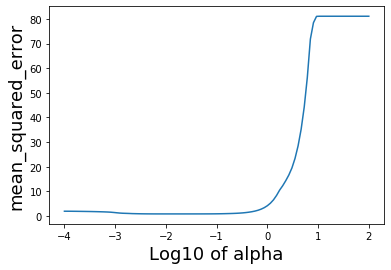

In [17]:
plt.plot(np.linspace(2, -4, 100),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [18]:
grid_search.best_params_

{'alpha': 0.017475284000076828}

In [19]:
lasso_reg = Lasso(alpha = grid_search.best_params_['alpha'])
lasso_reg.fit(X_poly_10_Standard ,y)

Lasso(alpha=0.017475284000076828, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
lasso_reg.coef_

array([0.80232282, 1.69069034, 7.88091603, 0.45144158, 0.        ,
       0.13811003, 0.        , 0.        , 0.        , 0.        ])

In [21]:
def get_shrinkage_mod(X,y,grid,methods = 1,return_type = 1):
    std_scaler = StandardScaler(with_mean = False)
    std_scaler.fit(X)
    X_Standard = std_scaler.transform(X)
    shrinkage_mod =  []
    idx = 1
    shrinkage_mod_columns = [['idx','lambda','coef'],['','','Intercept']]
    for variable in X.columns:
        shrinkage_mod_columns[0].append('coef')
        shrinkage_mod_columns[1].append(variable)
    for alpha in grid:
        if methods == 1:
            shrinkage_reg = Ridge(alpha = alpha)
        else:
            shrinkage_reg = Lasso(alpha = alpha)           
        shrinkage_reg.fit(X_Standard,y)
        shrinkage_mod.append([])
        shrinkage_mod[idx - 1].append(idx)
        shrinkage_mod[idx - 1].append(alpha)
        shrinkage_mod[idx - 1].append(shrinkage_reg.intercept_[0])
        #return_type为1返回Standardized Coefficients，否则反馈原模型的Coefficients
        if return_type == 1:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_[0])
            else:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_)
        else:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_[0].reshape(1,-1))[0].tolist())
            else:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_.reshape(1,-1))[0].tolist())
        idx += 1
    return  pd.DataFrame(np.array(shrinkage_mod),columns = shrinkage_mod_columns).set_index('idx')

In [22]:
lasso_mod = get_shrinkage_mod(X_poly_10,y,[grid_search.best_params_['alpha']],methods = 2,return_type = 2)

In [23]:
lasso_mod

lambda      coef                                                    \
              Intercept         X I(X ** 2) I(X ** 3) I(X ** 4) I(X ** 5)   
idx                                                                         
1.0  0.017475  1.309384  0.906419  1.519613  3.095127  0.093607       0.0   

                                                        
    I(X ** 6) I(X ** 7) I(X ** 8) I(X ** 9) I(X ** 10)  
idx                                                     
1.0  0.006164       0.0       0.0       0.0        0.0

In [24]:
lasso_mod['coef'].iloc[0][lasso_mod['coef'].iloc[0] != 0]

Intercept    1.309384
X            0.906419
I(X ** 2)    1.519613
I(X ** 3)    3.095127
I(X ** 4)    0.093607
I(X ** 6)    0.006164
Name: 1.0, dtype: float64

**从最终结果来看，与真实模型较为接近，过拟合出现的个别真实模型外系数都在0.1以下**

**(f) Now generate a response vector Y according to the model
Y = β 0 + β 7 X 7 + ?,
and perform best subset selection and the lasso. Discuss the
results obtained.**

In [25]:
y = 8 + 2 * (X ** 7) + epsilon
dataset = pd.DataFrame({'y':y,'X':X,'eps':epsilon})

In [26]:
reg = regsubsets(model,dataset,10)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


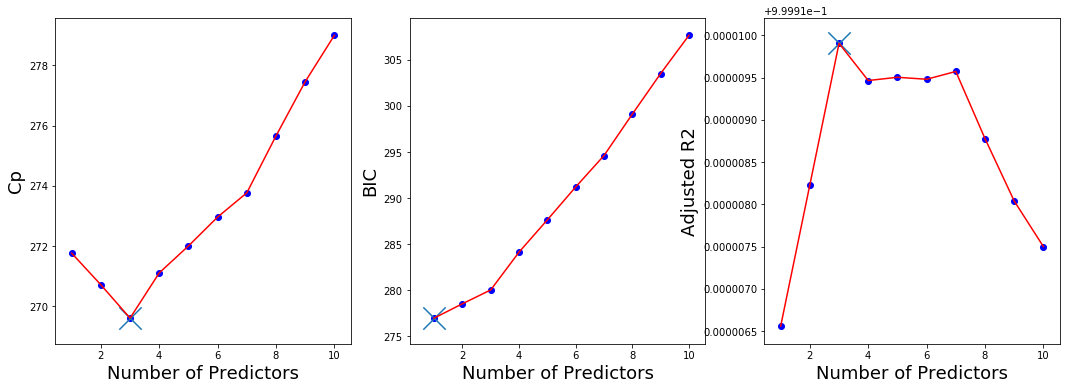

In [27]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(range(1,11),reg['cp'],'r-')
plt.scatter(range(1,11),reg['cp'],color = 'b')
plt.scatter(reg['cp'].astype('float64').idxmin(),reg['cp'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Cp", fontsize=18)
plt.subplot(132)
plt.plot(range(1,11),reg['bic'],'r-')
plt.scatter(range(1,11),reg['bic'],color = 'b')
plt.scatter(reg['bic'].astype('float64').idxmin(),reg['bic'].min(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"BIC", fontsize=18)
plt.subplot(133)
plt.plot(range(1,11),reg['adjr2'],'r-')
plt.scatter(range(1,11),reg['adjr2'],color = 'b')
plt.scatter(reg['adjr2'].astype('float64').idxmax(),reg['adjr2'].max(),marker = 'x',s=500)
plt.xlabel(u"Number of Predictors", fontsize=18)
plt.ylabel(u"Adjusted R2", fontsize=18)
plt.show()

In [28]:
print('best model obtained according to Cp:\n', reg['params'][reg['cp'].astype('float64').idxmin()])
print('best model obtained according to bic:\n', reg['params'][reg['bic'].astype('float64').idxmin()])
print('best model obtained according to adjr2:\n', reg['params'][reg['adjr2'].astype('float64').idxmax()])

best model obtained according to Cp:
 const        8.271801
I(X ** 2)   -0.320021
I(X ** 6)    0.020727
I(X ** 7)    2.003961
dtype: float64
best model obtained according to bic:
 const        8.154000
I(X ** 7)    2.002545
dtype: float64
best model obtained according to adjr2:
 const        8.271801
I(X ** 2)   -0.320021
I(X ** 6)    0.020727
I(X ** 7)    2.003961
dtype: float64


In [29]:
y,X_poly_10 = patsy.dmatrices(model + '+ 0', data = dataset, return_type="dataframe")
std_scaler = StandardScaler(with_mean=False)
std_scaler.fit(X_poly_10)
X_poly_10_Standard = std_scaler.transform(X_poly_10)
param_grid = [
{'alpha': 10 ** np.linspace(4, -7, 100) },
]
lasso_reg = Lasso(random_state = 1)
grid_search = GridSearchCV(lasso_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_poly_10_Standard ,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+04, 7.74263683e+03, 5.99484250e+03, 4.64158883e+03,
       3.59381366e+03, 2...
       1.29154967e-05, 1.00000000e-05, 7.74263683e-06, 5.99484250e-06,
       4.64158883e-06, 3.59381366e-06, 2.78255940e-06, 2.15443469e-06,
       1.66810054e-06, 1.29154967e-06, 1.00000000e-06, 7.74263683e-07,
       5.99484250e-07, 4.64158883e-07, 3.59381366e-07, 2.78255940e-07,
       2.15443469e-07, 1.66810054e-07, 1.29154967e-07, 1.00000000e-07])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

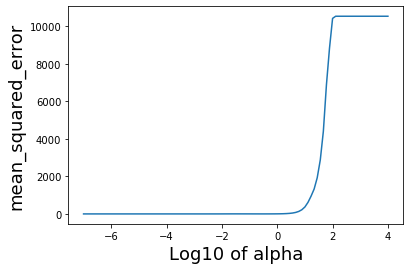

In [30]:
plt.plot(np.linspace(4, -7, 100),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [31]:
grid_search.best_params_

{'alpha': 0.002154434690031887}

In [32]:
grid_search.best_score_

-0.8698047720522535

In [33]:
lasso_mod = get_shrinkage_mod(X_poly_10,y,[grid_search.best_params_['alpha']],methods = 2,return_type = 2)

In [34]:
lasso_mod

lambda      coef                                                    \
              Intercept         X I(X ** 2) I(X ** 3) I(X ** 4) I(X ** 5)   
idx                                                                         
1.0  0.002154   8.23769  1.299686  0.023517 -4.710231 -0.312935  4.170111   

                                                        
    I(X ** 6) I(X ** 7) I(X ** 8) I(X ** 9) I(X ** 10)  
idx                                                     
1.0  0.012481  0.764471  0.013932  0.117014   0.000001

In [35]:
lasso_mod['coef'].iloc[0][lasso_mod['coef'].iloc[0] != 0]

Intercept     8.237690
X             1.299686
I(X ** 2)     0.023517
I(X ** 3)    -4.710231
I(X ** 4)    -0.312935
I(X ** 5)     4.170111
I(X ** 6)     0.012481
I(X ** 7)     0.764471
I(X ** 8)     0.013932
I(X ** 9)     0.117014
I(X ** 10)    0.000001
Name: 1.0, dtype: float64

**最优子集法无问题，但LASSO法对模型明显未正确拟合**

In [36]:
#更换随机种子实验
np.random.seed(2)
#X =  np.random.normal(loc = 0.0, scale = 1.0, size = 100)
X =  np.random.normal(0.0, 1.0, 100)
epsilon = np.random.normal(0.0, 1.0, 100)

In [37]:
y = 8 + 2 * (X ** 7) + epsilon
dataset = pd.DataFrame({'y':y,'X':X,'eps':epsilon})

In [38]:
y,X_poly_10 = patsy.dmatrices(model + '+ 0', data = dataset, return_type="dataframe")
std_scaler = StandardScaler(with_mean=False)
std_scaler.fit(X_poly_10)
X_poly_10_Standard = std_scaler.transform(X_poly_10)
param_grid = [
{'alpha': 10 ** np.linspace(4, -7, 100) },
]
lasso_reg = Lasso(random_state = 1)
grid_search = GridSearchCV(lasso_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_poly_10_Standard ,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+04, 7.74263683e+03, 5.99484250e+03, 4.64158883e+03,
       3.59381366e+03, 2...
       1.29154967e-05, 1.00000000e-05, 7.74263683e-06, 5.99484250e-06,
       4.64158883e-06, 3.59381366e-06, 2.78255940e-06, 2.15443469e-06,
       1.66810054e-06, 1.29154967e-06, 1.00000000e-06, 7.74263683e-07,
       5.99484250e-07, 4.64158883e-07, 3.59381366e-07, 2.78255940e-07,
       2.15443469e-07, 1.66810054e-07, 1.29154967e-07, 1.00000000e-07])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

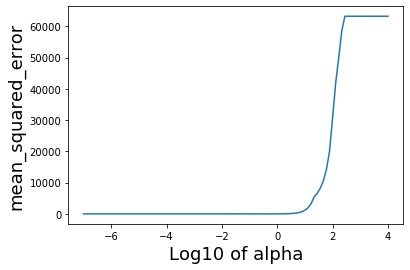

In [39]:
plt.plot(np.linspace(4, -7, 100),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [40]:
grid_search.best_params_

{'alpha': 0.3593813663804626}

In [41]:
lasso_mod = get_shrinkage_mod(X_poly_10,y,[grid_search.best_params_['alpha']],methods = 2,return_type = 2)

In [42]:
lasso_mod['coef'].iloc[0][lasso_mod['coef'].iloc[0] != 0]

Intercept    8.093422
X           -0.635399
I(X ** 5)    1.542652
I(X ** 7)    1.443066
I(X ** 9)    0.048411
Name: 1.0, dtype: float64

**更换随机种子后，拟合靠近，可见lasso受到了epsilon影响较大**

In [43]:
#增大样本量至100倍
np.random.seed(1)
X =  np.random.normal(0.0, 1.0, 10000)
epsilon = np.random.normal(0.0, 1.0, 10000)

In [44]:
y = 8 + 2 * (X ** 7) + epsilon
dataset = pd.DataFrame({'y':y,'X':X,'eps':epsilon})

In [45]:
y,X_poly_10 = patsy.dmatrices(model + '+ 0', data = dataset, return_type="dataframe")
std_scaler = StandardScaler(with_mean=False)
std_scaler.fit(X_poly_10)
X_poly_10_Standard = std_scaler.transform(X_poly_10)
param_grid = [
{'alpha': 10 ** np.linspace(4, -7, 100) },
]
lasso_reg = Lasso(random_state = 1)
grid_search = GridSearchCV(lasso_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_poly_10_Standard ,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+04, 7.74263683e+03, 5.99484250e+03, 4.64158883e+03,
       3.59381366e+03, 2...
       1.29154967e-05, 1.00000000e-05, 7.74263683e-06, 5.99484250e-06,
       4.64158883e-06, 3.59381366e-06, 2.78255940e-06, 2.15443469e-06,
       1.66810054e-06, 1.29154967e-06, 1.00000000e-06, 7.74263683e-07,
       5.99484250e-07, 4.64158883e-07, 3.59381366e-07, 2.78255940e-07,
       2.15443469e-07, 1.66810054e-07, 1.29154967e-07, 1.00000000e-07])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

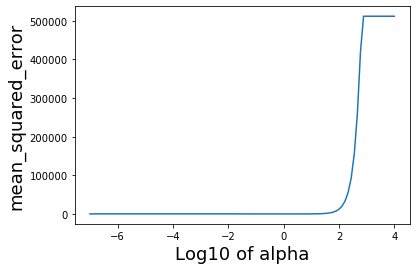

In [46]:
plt.plot(np.linspace(4, -7, 100),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [47]:
grid_search.best_params_

{'alpha': 1.0}

In [48]:
lasso_mod = get_shrinkage_mod(X_poly_10,y,[grid_search.best_params_['alpha']],methods = 2,return_type = 2)

In [49]:
lasso_mod['coef'].iloc[0][lasso_mod['coef'].iloc[0] != 0]

Intercept    8.026698
I(X ** 5)    0.067090
I(X ** 7)    1.983246
I(X ** 9)    0.000634
Name: 1.0, dtype: float64

**以上例子通过大量样本可抵消过拟合的问题**